In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
import seaborn as sns
from assignment3 import *
from datamodel import *
import matplotlib.pyplot as plt

In [20]:
data_index = ExperimentDataset.get_index(DatasetName.HEPMASS)
data_index

Error loading artifacts/HEPMASS/data_index.csv: could not find MARK
Error loading artifacts/HEPMASS/optimal.csv: unpickling stack underflow


,dataset,cluster_method,cluster_components,reduction_method,reduction_components,path
0,HEPMASS,KMEANS,36.0,ICA,8.0,artifacts/HEPMASS/100596749.pkl
1,HEPMASS,GMM,48.0,PCA,25.0,artifacts/HEPMASS/100950581.pkl
2,HEPMASS,NO_CLUSTERING,NaN,RANDOM_PROJECTIONS,4.0,artifacts/HEPMASS/103024984.pkl
3,HEPMASS,KMEANS,7.0,RANDOM_PROJECTIONS,4.0,artifacts/HEPMASS/108751032.pkl
4,HEPMASS,KMEANS,28.0,TRUNCATED_SVD,24.0,artifacts/HEPMASS/109807809.pkl
...,...,...,...,...,...,...
493,HEPMASS,KMEANS,11.0,PCA,25.0,artifacts/HEPMASS/nn_output_KMEANS_PCA.pickle
494,HEPMASS,KMEANS,21.0,RANDOM_PROJECTIONS,4.0,artifacts/HEPMASS/nn_output_KMEANS_RANDOM_PROJ...
495,HEPMASS,KMEANS,35.0,TRUNCATED_SVD,24.0,artifacts/HEPMASS/nn_output_KMEANS_TRUNCATED_S...
496,HEPMASS,NO_CLUSTERING,NaN,NO_METHOD,NaN,artifacts/HEPMASS/nn_output_NO_CLUSTERING_NO_M...


In [24]:
# visualize the cluster vs dm reduction vs score
def viz(data_index, cluster_method, reduction_method):
    datasets = data_index[
        (data_index['cluster_method'] == cluster_method) &
        (data_index['reduction_method'] == reduction_method)
    ]

    cluster_components, reduction_components, dm_components, score, unsupervised_score, wall_time, supervised_evaluation_method = [], [], [], [], [], [], []
    for index, row in datasets.iterrows():
        data = ExperimentDataset.load(row['path'])
        cluster_components.append(row['cluster_components'])
        reduction_components.append(row['reduction_components'])
        score.append(data.cluster.supervised_score)
        unsupervised_score.append(data.cluster.unsupervised_score)
        wall_time.append(data.cluster.wall_time)
        dm_components.append(data.reducer.n_components)
        supervised_evaluation_method.append(data.cluster.supervised_evaluation_method)

    supervised_evaluation_score = supervised_evaluation_method[0]

    results = pd.DataFrame({
        'cluster_components': cluster_components,
        'dimensionality_components': dm_components,
        'supervised_score': score,
        'unsupervised_score': unsupervised_score,
        'wall_time': wall_time
    })

    results.sort_values('cluster_components', inplace=True)

    fig, axs = plt.subplots(3, 2)

    axs[0, 0].plot(results['cluster_components'], results['supervised_score'])
    axs[0, 0].set_title(f'{cluster_method} & {reduction_method}')
    axs[0, 0].set_xlabel('Number of Clusters')
    axs[0, 0].set_ylabel(f'Score ({supervised_evaluation_score})')

    axs[0, 1].plot(results['cluster_components'], results['unsupervised_score'])
    axs[0, 1].set_title(f'{cluster_method} & {reduction_method}')
    axs[0, 1].set_xlabel('Number of Clusters')
    axs[0, 1].set_ylabel(f'Score (silhouette)')

    axs[0, 1].plot(results['cluster_components'], results['wall_time'])
    axs[0, 1].set_title(f'{cluster_method} & {reduction_method}')
    axs[0, 1].set_xlabel('Number of Clusters')
    axs[0, 1].set_ylabel('Wall Time (s)')

    c_method = ClusterMethod.NO_CLUSTERING.name

    path = data_index[
        (data_index['cluster_method'] == c_method) &
        (data_index['reduction_method'] == reduction_method)
    ].path.values[0]

    data = ExperimentDataset.load(path)
    history: List[ExplainedVarianceResult] = data.reducer.explained_variance_history
    explained_variance, n_components = [], []
    for variance in history:
        explained_variance.append(variance.explained_variance)
        n_components.append(variance.n_components)

    result = pd.DataFrame({
        'n_components': n_components,
        'explained_variance': explained_variance
    })

    result.sort_values('n_components', inplace=True, ascending=True)

    axs[1, 1].plot(result['n_components'], result['explained_variance'])
    axs[1, 1].set_xlabel('Number of Dimensionality Components')
    axs[1, 1].set_ylabel('Explained Variance')
    axs[1, 1].set_title(f'{reduction_method}')

    plt.tight_layout()
    plt.savefig(f'./visualization/{cluster_method}_{reduction_method}_scores.png')
    plt.show()
    plt.clf()

In [22]:
import dataframe_image as dfi

df1 = data_index[['reduction_method', 'reduction_components']].groupby('reduction_method').agg(['unique'])
df2 = data_index[['reduction_method', 'cluster_components']].groupby('cluster_method').agg(['unique'])

dfi.export(df1, "./visualization/unique_reduction_components.png")
dfi.export(df2, './visualization/unique_cluster_components.png')

KeyError: 'cluster_method'

C:\Users\kalie\AppData\Local\Temp\ipykernel_10608\3310934638.py:17: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=0,y=1,hue='target',palette=sns.color_palette("hls",10),data=df,
C:\Users\kalie\anaconda3\envs\unsupervised_learning_dm_reduction\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\kalie\AppData\Local\Temp\ipykernel_10608\3310934638.py:17: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=0,y=1,hue='target',palette=sns.color_palette("hls",10),data=df,
C:\Users\kalie\AppData\Local\Temp\ipykernel_10608\3310934638.py:17: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=0,y=1,hue='target',palette=sns.color_palette("hls",10),data=df,
C:\Users\kalie\AppData\Local\Temp\ipyke

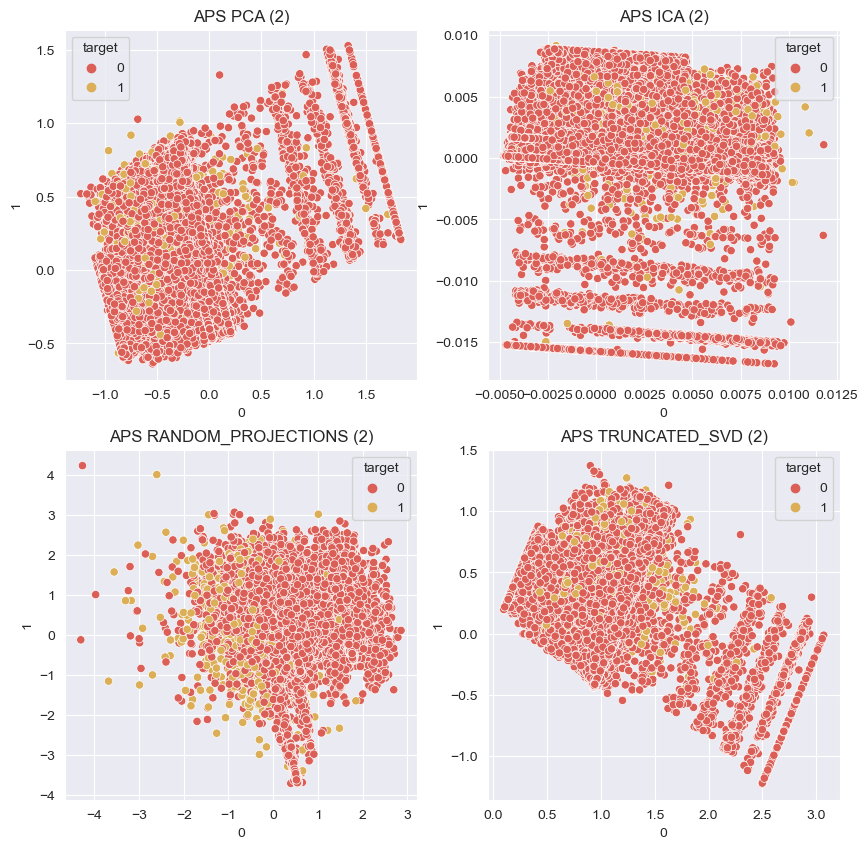

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
cluster_method = ClusterMethod.KMEANS
a = [(0, 0), (0, 1), (1, 0), (1, 1)]
data_index = pd.read_csv('./artifacts/APS_SYSTEM_FAILURE/data_index.csv')
raw = ExperimentDataset.load('./artifacts/APS_SYSTEM_FAILURE/raw_APS_SYSTEM_FAILURE.pkl')

for i, reduction_method in enumerate(ReductionMethod):
    if reduction_method == ReductionMethod.NO_METHOD:
        continue
    cd = reduction_method.value(n_components=2).fit_transform(raw.X_train)

    df = pd.DataFrame(cd)
    df['target']=raw.y_train

    x,y = a[i]

    sns.scatterplot(x=0,y=1,hue='target',palette=sns.color_palette("hls",10),data=df,
                    legend="full", ax=axs[x, y])
    axs[x,y].set_title(f'APS {reduction_method.name} ({2})')
plt.savefig(f'./visualization/{cluster_method.name}_{reduction_method.name}_projection.png')

C:\Users\kalie\AppData\Local\Temp\ipykernel_10608\3077072227.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


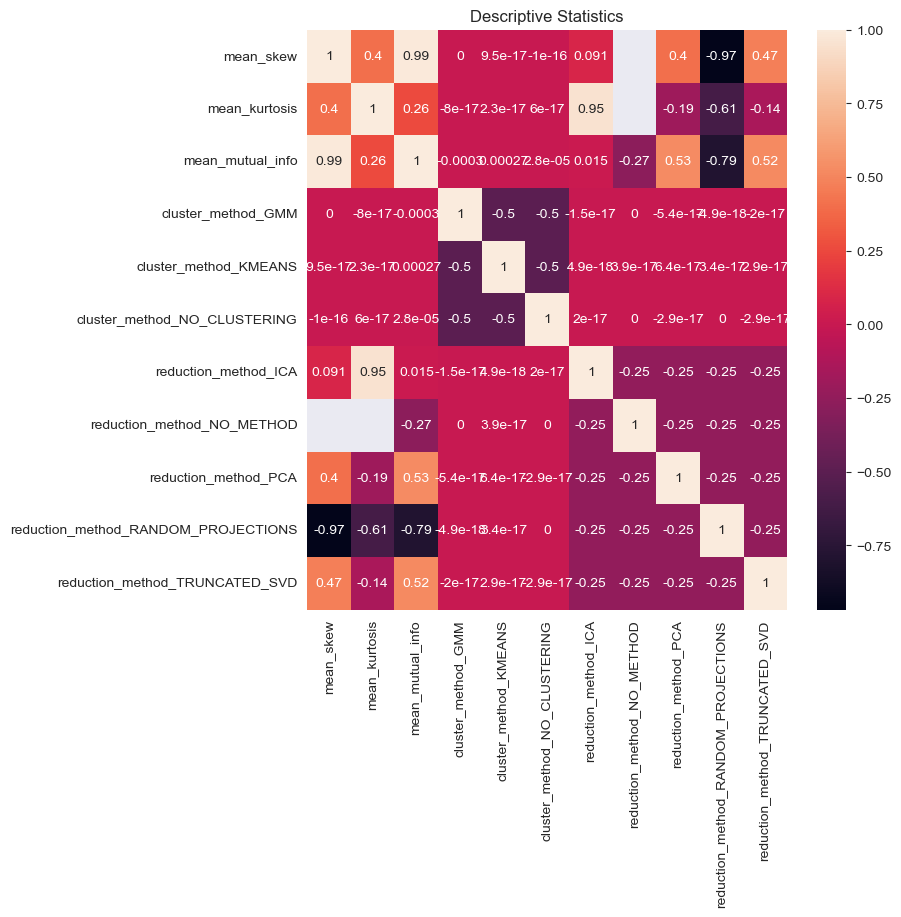

In [64]:
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import skew, kurtosis
from scipy.stats.stats import pearsonr

# mutual_info_classif(X=raw.X_train, y=raw.y_train)
data_index = pd.read_csv('./artifacts/APS_SYSTEM_FAILURE/data_index.csv')
rows = []
for cluster_method in ClusterMethod:
    for reduction_method in ReductionMethod:
        path = data_index[(data_index['reduction_method']==reduction_method.name)&(data_index['cluster_method']==cluster_method.name)].path.values[0]
        data = ExperimentDataset.load(path)
        # get skewness, kurtosis, and correlation with target
        avg_skew = np.mean(skew(data.X_train, axis=0, bias=True))
        avg_kurtosis = np.mean(kurtosis(data.X_train, axis=0, bias=True))
        corrs = []
        mean_mutual_info = np.mean(mutual_info_classif(data.X_train, data.y_train))

        rows.append(pd.DataFrame({
            'mean_skew': [avg_skew],
            'mean_kurtosis': [avg_kurtosis],
            'mean_mutual_info': [mean_mutual_info],
            'cluster_method': [cluster_method.name],
            'reduction_method': [reduction_method.name]
        }))

df = pd.concat(rows)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.margins(4)
plt.subplots_adjust(bottom=0.3, left=0.3)
dataplot = sns.heatmap(pd.get_dummies(df).corr(), annot=True)

plt.title('Descriptive Statistics')
plt.savefig('./visualization/corr.png')

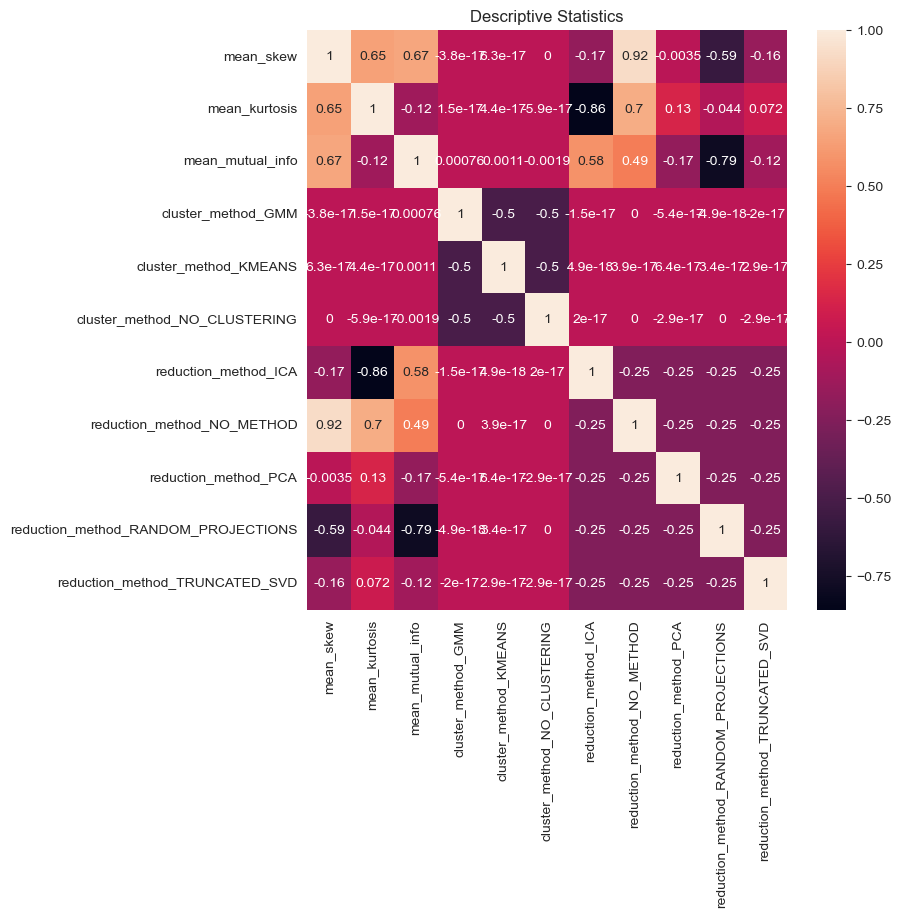

In [65]:
data_index = pd.read_csv('./artifacts/APS_SYSTEM_FAILURE/data_index.csv')
dmr = []
fig, axs = plt.subplots(2, 3, figsize=(10,10))
for i, cluster_method in enumerate(ClusterMethod):
    for j, reduction_method in enumerate(ReductionMethod):
        if cluster_method == ClusterMethod.NO_CLUSTERING:
            continue
        datasets = data_index[
            (data_index['cluster_method'] == cluster_method.name) &
            (data_index['reduction_method'] == reduction_method.name)
        ]

        cluster_components, reduction_components, dm_components, score, unsupervised_score, wall_time, supervised_evaluation_method = [], [], [], [], [], [], []
        for index, row in datasets.iterrows():
            data = ExperimentDataset.load(row['path'])
            cluster_components.append(row['cluster_components'])
            reduction_components.append(row['reduction_components'])
            score.append(data.cluster.supervised_score)
            unsupervised_score.append(data.cluster.unsupervised_score)
            wall_time.append(data.cluster.wall_time)
            dm_components.append(data.reducer.n_components)
            supervised_evaluation_method.append(data.cluster.supervised_evaluation_method)

        supervised_evaluation_score = supervised_evaluation_method[0]

        results = pd.DataFrame({
            'cluster_components': cluster_components,
            'dimensionality_components': dm_components,
            'supervised_score': score,
            'unsupervised_score': unsupervised_score,
            'wall_time': wall_time
        })

        results.sort_values('cluster_components', inplace=True)

        axs[i, 0].plot(results['cluster_components'], results['supervised_score'])
        axs[i, 0].set_title(cluster_method.name)
        axs[i, 0].set_xlabel('Number of Clusters')
        axs[i, 0].set_ylabel(f'Score ({supervised_evaluation_score})')

        axs[i, 1].plot(results['cluster_components'], results['unsupervised_score'])
        axs[i, 1].set_title(cluster_method.name)
        axs[i, 1].set_xlabel('Number of Clusters')
        axs[i, 1].set_ylabel(f'Score (silhouette)')

        axs[i, 2].plot(results['cluster_components'], results['wall_time'])
        axs[i, 2].set_title(cluster_method.name)
        axs[i, 2].set_xlabel('Number of Clusters')
        axs[i, 2].set_ylabel('Wall Time (s)')

        dmr.append(reduction_method.name)

# dmr_methods = list(ReductionMethod)
# dmr_methods.remove(ReductionMethod.NO_METHOD)
# dmr_methods = [method.name for method in dmr_methods]
plt.tight_layout()
plt.legend(dmr, loc="lower left")
plt.savefig(f'./visualization/all_scores.png')
plt.clf()

<Figure size 1000x1000 with 0 Axes>

In [ ]:
loss = []
val = []
acc = []
val_a = []

files = glob.glob(r"./artifacts/HEPMASS/nn_output*.pickle")
files

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

for cluster_method in ClusterMethod:
    cluster_method = cluster_method.name
    for dmr_method in ReductionMethod:
        dmr_method = dmr_method.name

        if not os.path.isfile(f'./artifacts/APS_SYSTEM_FAILURE/nn_output_{cluster_method}_{dmr_method}.pickle'):
            continue

        dataset = ExperimentDataset.load(f'./artifacts/APS_SYSTEM_FAILURE/nn_output_{cluster_method}_{dmr_method}.pickle')

        axs[0, 0].plot(dataset.neural_network_output.fitness_curve['loss'], label = f"Loss: {cluster_method} & {dmr_method}")
        axs[0, 0].set_title('Loss')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Binary Crossentropy Loss')

        axs[0, 1].plot(dataset.neural_network_output.fitness_curve['val_loss'], label = f"{cluster_method} & {dmr_method}")
        axs[0, 1].set_title('Validation Loss')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Binary Crossentropy Loss')

        axs[1, 0].plot(dataset.neural_network_output.fitness_curve['accuracy'], label = f"{cluster_method} & {dmr_method}")
        axs[1, 0].set_title('Accuracy')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Binary Crossentropy Loss')

        axs[1, 1].plot(dataset.neural_network_output.fitness_curve['val_accuracy'], label = f"{cluster_method} & {dmr_method}")
        axs[1, 1].set_title('Validation Accuracy')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Binary Crossentropy Loss')

plt.tight_layout()
plt.legend()
plt.savefig('./visualization/losses.png')
plt.clf()

<Figure size 1000x1000 with 0 Axes>

In [79]:
df = pd.read_csv('./artifacts/HEPMASS/optimal.csv')
path = df[(df['reduction_method'] == 'ReductionMethod.ICA') * (df['cluster_method'] == 'ClusterMethod.GMM')].path.values[0]
data = ExperimentDataset.load(path)
data.reducer.n_components

C:\Users\kalie\anaconda3\envs\unsupervised_learning_dm_reduction\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


141

In [72]:
data = ExperimentDataset.load('./artifacts/HEPMASS/raw_HEPMASS.pkl')
data.X_train.shape[1]

28

In [7]:
data_index = pd.read_csv('./artifacts/HEPMASS/data_index.csv')

for method in ClusterMethod:
    path = data_index[(data_index['reduction_method']==ReductionMethod.NO_METHOD.name)&(data_index['cluster_method']==method.name)].path.values[0]
    data = ExperimentDataset.load(path)
    print(f'{method.name}: {data.cluster.wall_time}')

for method in ReductionMethod:
    path = data_index[(data_index['reduction_method']==method.name)&(data_index['cluster_method']==ClusterMethod.NO_CLUSTERING.name)].path.values[0]
    data = ExperimentDataset.load(path)
    print(f'{method.name}: {data.reducer.training_wall_time}')

KMEANS: 1.375994
GMM: 1.99603
NO_CLUSTERING: None
PCA: 0.037000417709350586
ICA: 0.06400275230407715
RANDOM_PROJECTIONS: 0.0029942989349365234
TRUNCATED_SVD: 0.212996244430542
NO_METHOD: None


In [55]:
# calculate kurtosis

raw = ExperimentDataset.load('./artifacts/APS_SYSTEM_FAILURE/raw_APS_SYSTEM_FAILURE.pkl')

from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from scipy.stats import kurtosis

for i in range(0, 40):
    reduced_data = PCA(n_components=data.reducer.n_components).fit_transform(raw.X_train)
    print(f'{i}: {np.mean(kurtosis(reduced_data))}')

0: 2768.997834907323
1: 2768.997834907323
2: 2768.997834907323
3: 2768.997834907323
4: 2768.997834907323
5: 2768.997834907323
6: 2768.997834907323
7: 2768.997834907323
8: 2768.997834907323
9: 2768.997834907323
10: 2768.997834907323
11: 2768.997834907323
12: 2768.997834907323
13: 2768.997834907323
14: 2768.997834907323
15: 2768.997834907323
16: 2768.997834907323
17: 2768.997834907323
18: 2768.997834907323
19: 2768.997834907323
20: 2768.997834907323
21: 2768.997834907323
22: 2768.997834907323
23: 2768.997834907323
24: 2768.997834907323
25: 2768.997834907323
26: 2768.997834907323
27: 2768.997834907323
28: 2768.997834907323
29: 2768.997834907323
30: 2768.997834907323
31: 2768.997834907323
32: 2768.997834907323
33: 2768.997834907323
34: 2768.997834907323
35: 2768.997834907323
36: 2768.997834907323
37: 2768.997834907323
38: 2768.997834907323
39: 2768.997834907323


In [54]:
a = kurtosis(raw.X_train)

np.mean(a[np.logical_not(np.isnan(a))])

5546.084781990394